# CN7023 - Optimizer Comparison on CIFAR-10

**Research Question:** How do different optimization algorithms (SGD, SGD+Momentum, Adam, RMSprop) affect CNN training dynamics, convergence speed, and generalization on CIFAR-10?

**Experiments:** 4 optimizers on identical CNN architecture
- SGD (lr=0.1, no momentum)
- SGD + Momentum (lr=0.1, momentum=0.9) 
- Adam (lr=0.001)
- RMSprop (lr=0.001)

## 1. Setup: Libraries and Configuration

In [1]:
import torch
import torch.nn as nn
import torch.optim as optim
import torchvision.transforms as transforms
import torchvision.datasets as dsets
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix, classification_report, accuracy_score
import pandas as pd
import os, json, time
from datetime import datetime

torch.manual_seed(42)
np.random.seed(42)

# Use Apple Silicon GPU (MPS) if available, otherwise CUDA, otherwise CPU
if torch.backends.mps.is_available():
    device = torch.device('mps')
    print(f"Device: mps (Apple Silicon GPU)")
elif torch.cuda.is_available():
    device = torch.device('cuda')
    print(f"Device: cuda (NVIDIA GPU)")
else:
    device = torch.device('cpu')
    print(f"Device: cpu")
    
print(f"PyTorch version: {torch.__version__}")

Device: mps (Apple Silicon GPU)
PyTorch version: 2.10.0


## 2. Configuration

In [2]:
BATCH_SIZE = 128
NUM_EPOCHS = 10
NUM_CLASSES = 10
OUT_CHANNELS_1 = 32
OUT_CHANNELS_2 = 64

OPTIMIZER_CONFIGS = {
    'SGD': {'lr': 0.1, 'momentum': 0.0},
    'SGD_Momentum': {'lr': 0.1, 'momentum': 0.9},
    'Adam': {'lr': 0.001, 'betas': (0.9, 0.999)},
    'RMSprop': {'lr': 0.001, 'alpha': 0.99}
}

DATA_DIR = '../data'
MODELS_DIR = '../models'
PLOTS_DIR = '../results/plots'
METRICS_DIR = '../results/metrics'

os.makedirs(MODELS_DIR, exist_ok=True)
os.makedirs(PLOTS_DIR, exist_ok=True)
os.makedirs(METRICS_DIR, exist_ok=True)

CLASS_NAMES = ['airplane', 'automobile', 'bird', 'cat', 'deer',
               'dog', 'frog', 'horse', 'ship', 'truck']

print("Configuration loaded")
for name, cfg in OPTIMIZER_CONFIGS.items():
    print(f"  {name}: lr={cfg['lr']}")

Configuration loaded
  SGD: lr=0.1
  SGD_Momentum: lr=0.1
  Adam: lr=0.001
  RMSprop: lr=0.001


## 3. CNN Architecture

2-layer CNN: 3→32→64 channels, MaxPool, FC→10 classes

In [3]:
class CNN_CIFAR10(nn.Module):
    def __init__(self, out_1=32, out_2=64):
        super(CNN_CIFAR10, self).__init__()
        self.cnn1 = nn.Conv2d(3, out_1, kernel_size=5, padding=2)
        self.maxpool1 = nn.MaxPool2d(2)
        self.cnn2 = nn.Conv2d(out_1, out_2, kernel_size=5, padding=2)
        self.maxpool2 = nn.MaxPool2d(2)
        self.fc1 = nn.Linear(out_2 * 8 * 8, NUM_CLASSES)
    
    def forward(self, x):
        x = torch.relu(self.cnn1(x))
        x = self.maxpool1(x)
        x = torch.relu(self.cnn2(x))
        x = self.maxpool2(x)
        x = x.view(x.size(0), -1)
        return self.fc1(x)
    
    def count_parameters(self):
        return sum(p.numel() for p in self.parameters() if p.requires_grad)

test_model = CNN_CIFAR10(OUT_CHANNELS_1, OUT_CHANNELS_2)
print(f"Architecture:\n{test_model}")
print(f"\nParameters: {test_model.count_parameters():,}")

Architecture:
CNN_CIFAR10(
  (cnn1): Conv2d(3, 32, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
  (maxpool1): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (cnn2): Conv2d(32, 64, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
  (maxpool2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (fc1): Linear(in_features=4096, out_features=10, bias=True)
)

Parameters: 94,666


## 4. Data Loading

CIFAR-10: 50k train → 40k train + 10k val, 10k test

In [4]:
# Download once, use cached data after
print("Downloading CIFAR-10 (only happens once)...")
dataset_train = dsets.CIFAR10(DATA_DIR, train=True, download=True)
dataset_test = dsets.CIFAR10(DATA_DIR, train=False, download=True)
print("Download complete!")

# Define transforms
transform_train = transforms.Compose([
    transforms.RandomCrop(32, padding=4),
    transforms.RandomHorizontalFlip(),
    transforms.ToTensor(),
    transforms.Normalize((0.4914, 0.4822, 0.4465), (0.2023, 0.1994, 0.2010))
])

transform_test = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.4914, 0.4822, 0.4465), (0.2023, 0.1994, 0.2010))
])

# Split indices for train/val
train_size = int(0.8 * len(dataset_train))
val_size = len(dataset_train) - train_size
indices = list(range(len(dataset_train)))
np.random.seed(42)
np.random.shuffle(indices)
train_indices = indices[:train_size]
val_indices = indices[train_size:]

# Create datasets with appropriate transforms
from torch.utils.data import Subset

class TransformSubset(torch.utils.data.Dataset):
    def __init__(self, subset, transform=None):
        self.subset = subset
        self.transform = transform
    
    def __getitem__(self, idx):
        img, label = self.subset[idx]
        if self.transform:
            img = self.transform(img)
        return img, label
    
    def __len__(self):
        return len(self.subset)

train_dataset = TransformSubset(Subset(dataset_train, train_indices), transform_train)
val_dataset = TransformSubset(Subset(dataset_train, val_indices), transform_test)
test_dataset = TransformSubset(dataset_test, transform_test)

print(f"Train: {len(train_dataset):,} | Val: {len(val_dataset):,} | Test: {len(test_dataset):,}")

/Users/omoba/Documents/masters/jupyter-labs-env/lib/python3.13/site-packages/torchvision/datasets/cifar.py:83: VisibleDeprecationWarning: dtype(): align should be passed as Python or NumPy boolean but got `align=0`. Did you mean to pass a tuple to create a subarray type? (Deprecated NumPy 2.4)
  entry = pickle.load(f, encoding="latin1")


Download complete!
Train: 40,000 | Val: 10,000 | Test: 10,000


## 5. Visualize Dataset

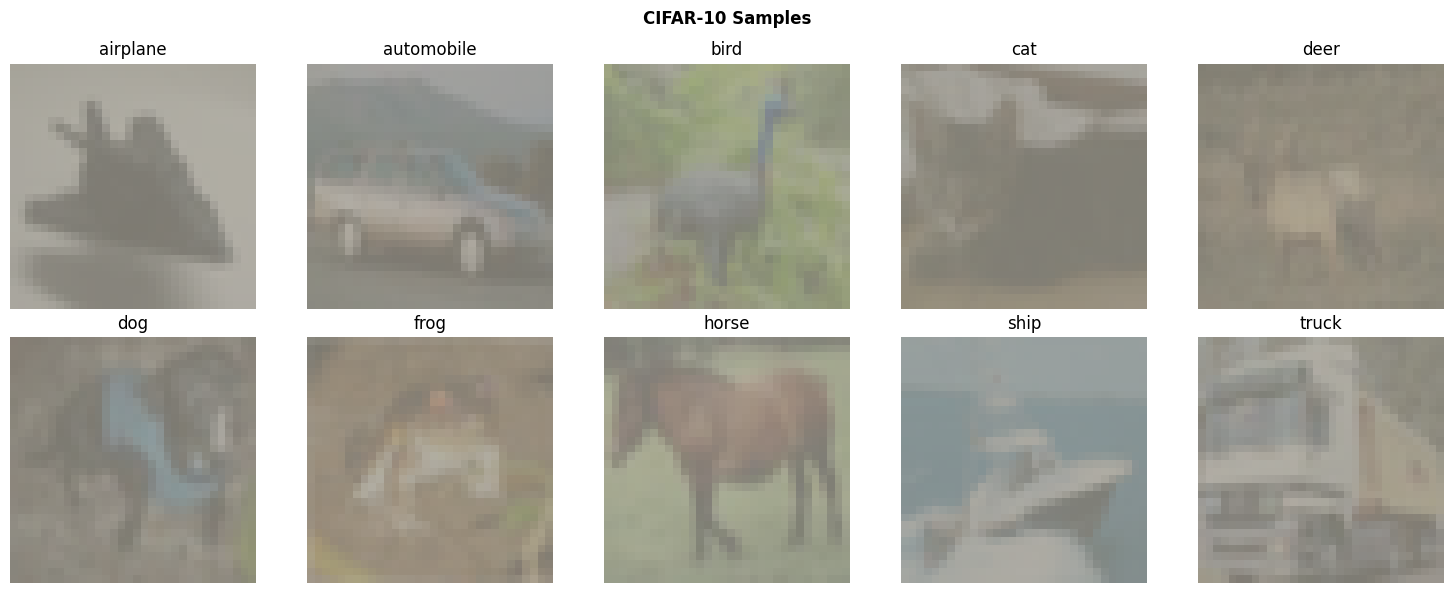

In [5]:
fig, axes = plt.subplots(2, 5, figsize=(15, 6))
axes = axes.ravel()
samples = {}

for img, label in dataset_train:
    if label not in samples:
        img_tensor = transforms.ToTensor()(img)
        img_denorm = img_tensor * torch.tensor([0.2023, 0.1994, 0.2010]).view(3,1,1)
        img_denorm = img_denorm + torch.tensor([0.4914, 0.4822, 0.4465]).view(3,1,1)
        samples[label] = torch.clamp(img_denorm, 0, 1)
    if len(samples) == 10:
        break

for idx in range(10):
    axes[idx].imshow(samples[idx].permute(1,2,0).numpy())
    axes[idx].set_title(CLASS_NAMES[idx])
    axes[idx].axis('off')

plt.suptitle('CIFAR-10 Samples', fontweight='bold')
plt.tight_layout()
plt.savefig(f"{PLOTS_DIR}/cifar10_samples.png", dpi=150, bbox_inches='tight')
plt.show()

## 6. Training & Evaluation Functions

In [6]:
def train_model(model, train_loader, val_loader, criterion, optimizer, epochs, device, name):
    history = {'train_loss': [], 'train_acc': [], 'val_loss': [], 'val_acc': [], 'epoch_times': []}
    model = model.to(device)
    
    print(f"\n{'='*70}\nTraining: {name}\n{'='*70}")
    
    for epoch in range(epochs):
        start = time.time()
        model.train()
        train_loss, train_correct, train_total = 0, 0, 0
        
        for data, target in train_loader:
            data, target = data.to(device), target.to(device)
            optimizer.zero_grad()
            output = model(data)
            loss = criterion(output, target)
            loss.backward()
            optimizer.step()
            train_loss += loss.item()
            _, pred = torch.max(output, 1)
            train_total += target.size(0)
            train_correct += (pred == target).sum().item()
        
        model.eval()
        val_loss, val_correct, val_total = 0, 0, 0
        with torch.no_grad():
            for data, target in val_loader:
                data, target = data.to(device), target.to(device)
                output = model(data)
                val_loss += criterion(output, target).item()
                _, pred = torch.max(output, 1)
                val_total += target.size(0)
                val_correct += (pred == target).sum().item()
        
        history['train_loss'].append(train_loss / len(train_loader))
        history['train_acc'].append(100 * train_correct / train_total)
        history['val_loss'].append(val_loss / len(val_loader))
        history['val_acc'].append(100 * val_correct / val_total)
        history['epoch_times'].append(time.time() - start)
        
        print(f"Epoch {epoch+1:2d}/{epochs} | Train: {history['train_loss'][-1]:.4f}/{history['train_acc'][-1]:6.2f}% | "
              f"Val: {history['val_loss'][-1]:.4f}/{history['val_acc'][-1]:6.2f}% | Time: {history['epoch_times'][-1]:.1f}s")
    
    print(f"{'='*70}\nCompleted! Final Val Acc: {history['val_acc'][-1]:.2f}%\n")
    return history

In [7]:
def evaluate_model(model, test_loader, device, class_names):
    model.eval()
    model = model.to(device)
    predictions, targets = [], []
    
    with torch.no_grad():
        for data, target in test_loader:
            data, target = data.to(device), target.to(device)
            output = model(data)
            _, pred = torch.max(output, 1)
            predictions.extend(pred.cpu().numpy())
            targets.extend(target.cpu().numpy())
    
    accuracy = accuracy_score(targets, predictions)
    conf_matrix = confusion_matrix(targets, predictions)
    report = classification_report(targets, predictions, target_names=class_names, 
                                  output_dict=True, zero_division=0)
    
    print(f"Test Accuracy: {accuracy*100:.2f}%")
    return {'accuracy': accuracy, 'predictions': predictions, 'targets': targets,
            'confusion_matrix': conf_matrix, 'classification_report': report}

In [8]:
def plot_training(history, name):
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 5))
    epochs = range(1, len(history['train_loss']) + 1)
    
    ax1.plot(epochs, history['train_loss'], 'o-', label='Train', linewidth=2)
    ax1.plot(epochs, history['val_loss'], 'o-', label='Val', linewidth=2)
    ax1.set_xlabel('Epoch')
    ax1.set_ylabel('Loss')
    ax1.set_title(f'{name} - Loss')
    ax1.legend()
    ax1.grid(alpha=0.3)
    
    ax2.plot(epochs, history['train_acc'], 'o-', label='Train', linewidth=2)
    ax2.plot(epochs, history['val_acc'], 'o-', label='Val', linewidth=2)
    ax2.set_xlabel('Epoch')
    ax2.set_ylabel('Accuracy (%)')
    ax2.set_title(f'{name} - Accuracy')
    ax2.legend()
    ax2.grid(alpha=0.3)
    
    plt.tight_layout()
    plt.savefig(f"{PLOTS_DIR}/{name.lower().replace(' ', '_').replace('+','')}_training.png", 
                dpi=150, bbox_inches='tight')
    plt.show()

In [9]:
def plot_confusion(conf_matrix, class_names, name):
    plt.figure(figsize=(10, 8))
    sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues',
                xticklabels=class_names, yticklabels=class_names)
    plt.xlabel('Predicted')
    plt.ylabel('True')
    plt.title(f'{name} - Confusion Matrix')
    plt.tight_layout()
    plt.savefig(f"{PLOTS_DIR}/{name.lower().replace(' ', '_').replace('+','')}_confusion.png", 
                dpi=150, bbox_inches='tight')
    plt.show()

## 7. Create Data Loaders

In [10]:
train_loader = torch.utils.data.DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True, 
                                          num_workers=0, pin_memory=True if torch.cuda.is_available() else False)
val_loader = torch.utils.data.DataLoader(val_dataset, batch_size=BATCH_SIZE, shuffle=False,
                                        num_workers=0, pin_memory=True if torch.cuda.is_available() else False)
test_loader = torch.utils.data.DataLoader(test_dataset, batch_size=BATCH_SIZE, shuffle=False,
                                         num_workers=0, pin_memory=True if torch.cuda.is_available() else False)

print(f"Train batches: {len(train_loader)} | Val batches: {len(val_loader)} | Test batches: {len(test_loader)}")

Train batches: 313 | Val batches: 79 | Test batches: 79


## 8. Experiment 1: SGD


Training: SGD
Epoch  1/10 | Train: 1.8088/ 34.58% | Val: 1.5361/ 44.94% | Time: 13.0s
Epoch  2/10 | Train: 1.4680/ 47.84% | Val: 1.3331/ 52.46% | Time: 9.7s
Epoch  3/10 | Train: 1.3081/ 53.81% | Val: 1.1242/ 60.54% | Time: 9.7s
Epoch  4/10 | Train: 1.2294/ 56.94% | Val: 1.1961/ 59.19% | Time: 9.7s
Epoch  5/10 | Train: 1.1377/ 60.42% | Val: 1.0222/ 64.49% | Time: 9.7s
Epoch  6/10 | Train: 1.0861/ 62.31% | Val: 1.0464/ 64.62% | Time: 9.6s
Epoch  7/10 | Train: 1.0413/ 63.72% | Val: 0.9784/ 67.40% | Time: 9.7s
Epoch  8/10 | Train: 1.0069/ 65.14% | Val: 0.9232/ 69.01% | Time: 9.6s
Epoch  9/10 | Train: 0.9794/ 66.12% | Val: 0.9478/ 67.43% | Time: 9.8s
Epoch 10/10 | Train: 0.9393/ 67.45% | Val: 0.9427/ 67.99% | Time: 9.7s
Completed! Final Val Acc: 67.99%



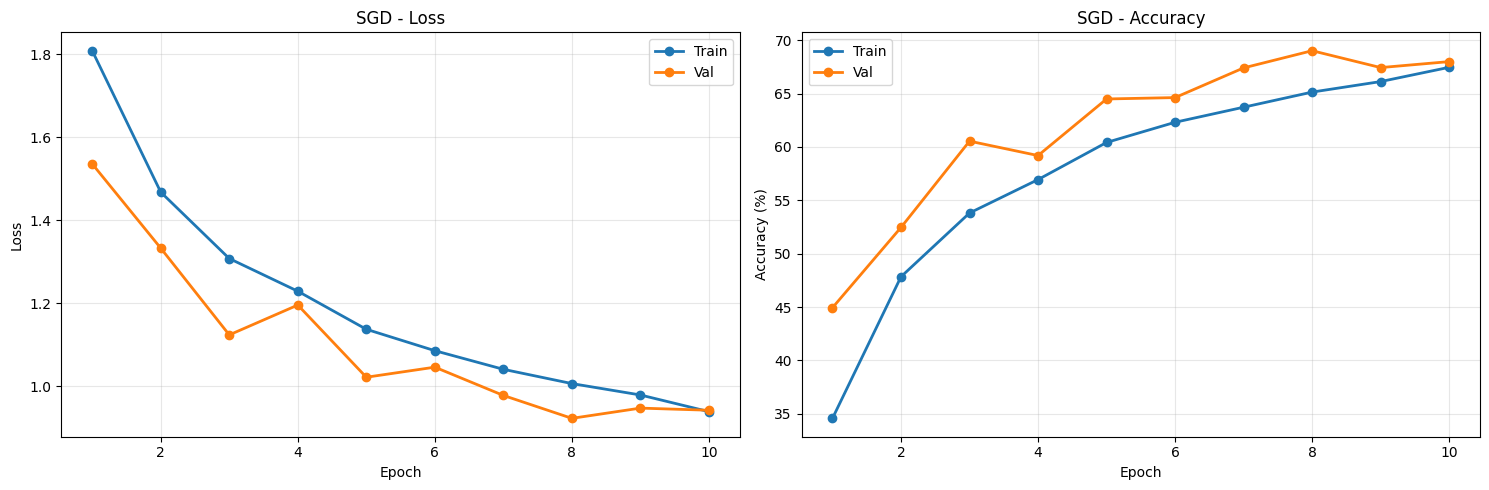

Test Accuracy: 68.30%


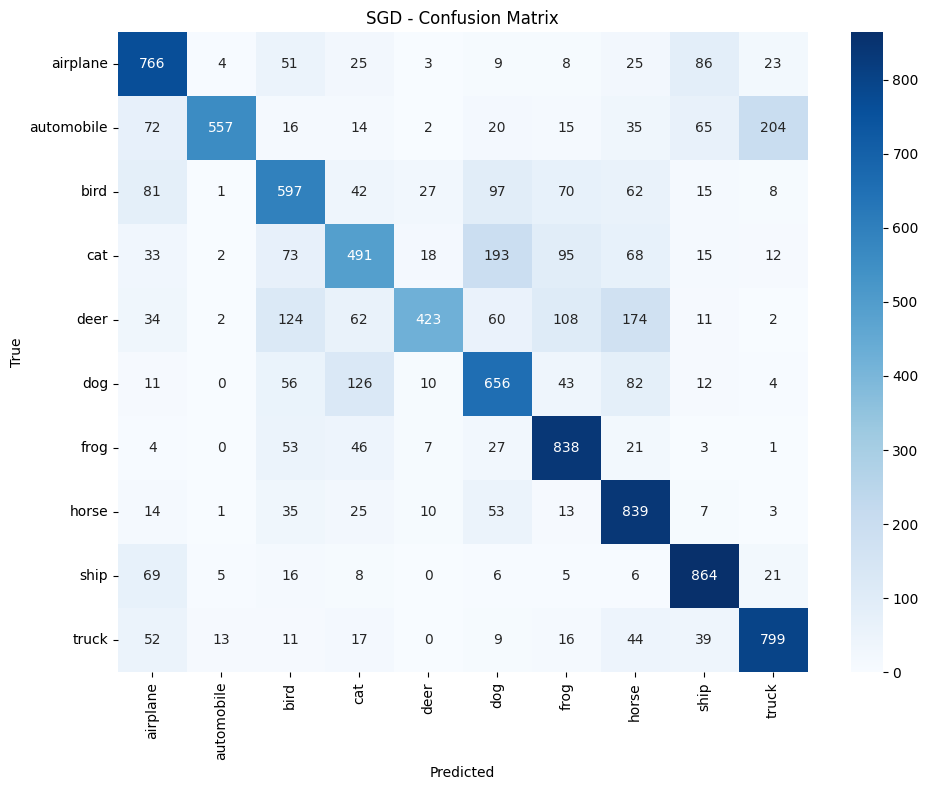

In [11]:
model_sgd = CNN_CIFAR10(OUT_CHANNELS_1, OUT_CHANNELS_2)
criterion = nn.CrossEntropyLoss()
optimizer_sgd = optim.SGD(model_sgd.parameters(), lr=0.1, momentum=0.0)

history_sgd = train_model(model_sgd, train_loader, val_loader, criterion, 
                         optimizer_sgd, NUM_EPOCHS, device, "SGD")
plot_training(history_sgd, "SGD")

results_sgd = evaluate_model(model_sgd, test_loader, device, CLASS_NAMES)
plot_confusion(results_sgd['confusion_matrix'], CLASS_NAMES, "SGD")

torch.save({'model': model_sgd.state_dict(), 'history': history_sgd, 'results': results_sgd},
          f"{MODELS_DIR}/sgd_model.pth")

## 9. Experiment 2: SGD + Momentum


Training: SGD + Momentum
Epoch  1/10 | Train: 1.6497/ 40.53% | Val: 1.3837/ 51.94% | Time: 10.2s
Epoch  2/10 | Train: 1.3046/ 53.71% | Val: 1.1905/ 58.00% | Time: 9.8s
Epoch  3/10 | Train: 1.1674/ 58.90% | Val: 1.0672/ 63.32% | Time: 9.7s
Epoch  4/10 | Train: 1.0935/ 61.95% | Val: 0.9684/ 66.58% | Time: 9.7s
Epoch  5/10 | Train: 1.0196/ 64.66% | Val: 0.9298/ 67.75% | Time: 9.7s
Epoch  6/10 | Train: 0.9719/ 66.61% | Val: 0.9422/ 68.06% | Time: 9.6s
Epoch  7/10 | Train: 0.9298/ 67.86% | Val: 0.8482/ 71.18% | Time: 9.8s
Epoch  8/10 | Train: 0.8929/ 69.02% | Val: 0.8674/ 71.05% | Time: 9.8s
Epoch  9/10 | Train: 0.8719/ 70.25% | Val: 0.8394/ 71.74% | Time: 9.7s
Epoch 10/10 | Train: 0.8436/ 71.03% | Val: 0.7889/ 73.32% | Time: 9.8s
Completed! Final Val Acc: 73.32%



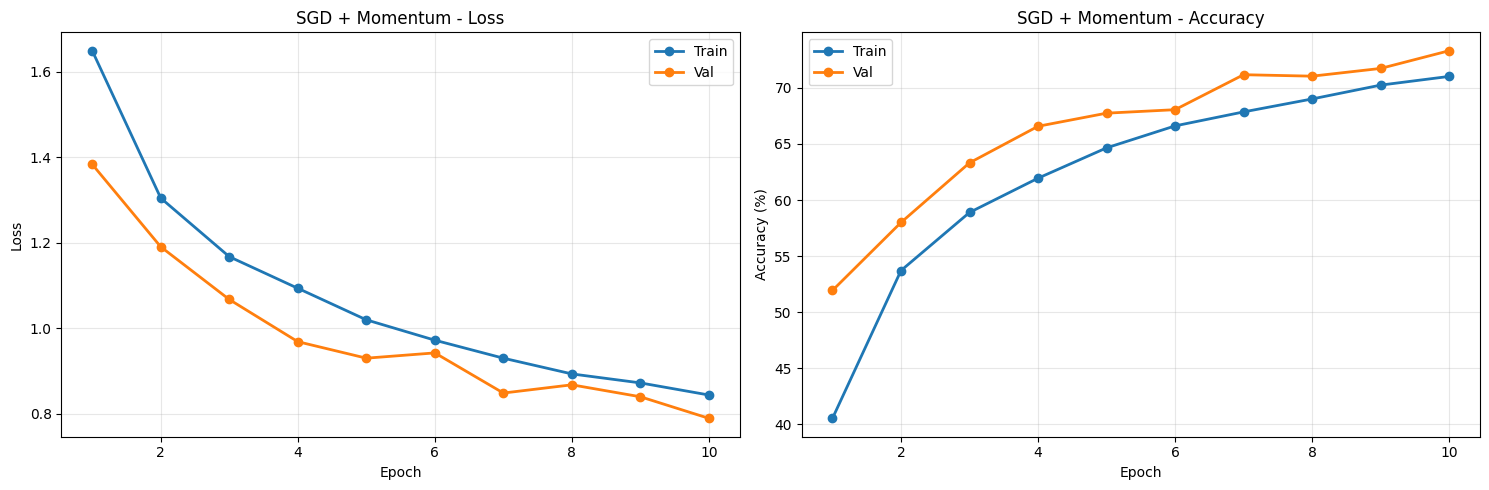

Test Accuracy: 73.07%


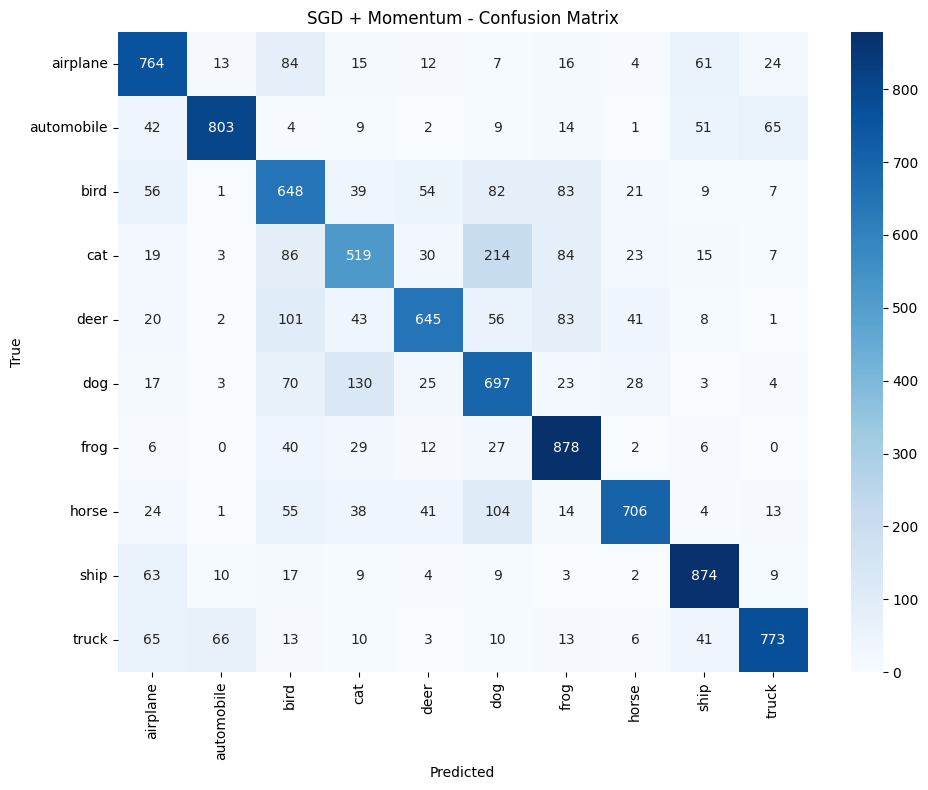

In [24]:
model_sgd_m = CNN_CIFAR10(OUT_CHANNELS_1, OUT_CHANNELS_2)
optimizer_sgd_m = optim.SGD(model_sgd_m.parameters(), lr=0.01, momentum=0.9)

history_sgd_m = train_model(model_sgd_m, train_loader, val_loader, criterion,
                           optimizer_sgd_m, NUM_EPOCHS, device, "SGD + Momentum")
plot_training(history_sgd_m, "SGD + Momentum")

results_sgd_m = evaluate_model(model_sgd_m, test_loader, device, CLASS_NAMES)
plot_confusion(results_sgd_m['confusion_matrix'], CLASS_NAMES, "SGD + Momentum")

torch.save({'model': model_sgd_m.state_dict(), 'history': history_sgd_m, 'results': results_sgd_m},
          f"{MODELS_DIR}/sgd_momentum_model.pth")

## 10. Experiment 3: Adam


Training: Adam
Epoch  1/10 | Train: 1.6189/ 41.89% | Val: 1.3318/ 52.55% | Time: 10.2s
Epoch  2/10 | Train: 1.2877/ 54.66% | Val: 1.1482/ 60.07% | Time: 9.7s
Epoch  3/10 | Train: 1.1622/ 59.30% | Val: 1.0567/ 63.21% | Time: 9.7s
Epoch  4/10 | Train: 1.0921/ 61.47% | Val: 0.9899/ 65.46% | Time: 9.7s
Epoch  5/10 | Train: 1.0414/ 63.48% | Val: 0.9075/ 68.75% | Time: 9.9s
Epoch  6/10 | Train: 0.9896/ 65.64% | Val: 0.9289/ 67.62% | Time: 9.9s
Epoch  7/10 | Train: 0.9672/ 66.32% | Val: 0.9182/ 68.28% | Time: 9.7s
Epoch  8/10 | Train: 0.9391/ 67.41% | Val: 0.8740/ 69.96% | Time: 9.7s
Epoch  9/10 | Train: 0.9103/ 68.53% | Val: 0.9258/ 68.24% | Time: 9.9s
Epoch 10/10 | Train: 0.8917/ 69.03% | Val: 0.8326/ 72.09% | Time: 9.8s
Completed! Final Val Acc: 72.09%



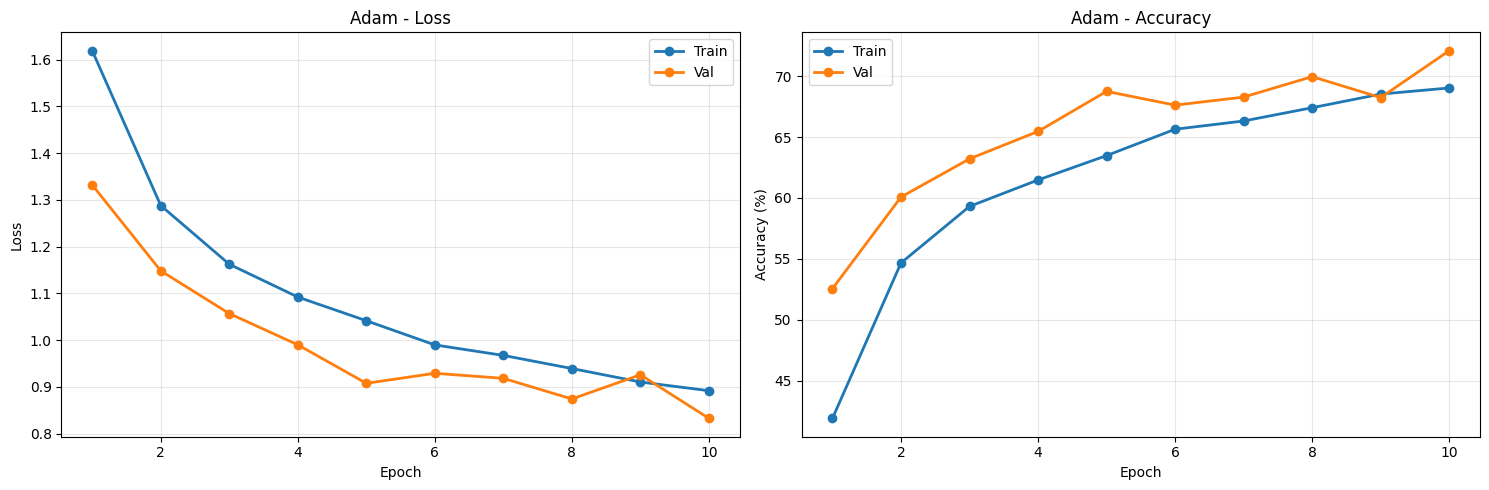

Test Accuracy: 72.46%


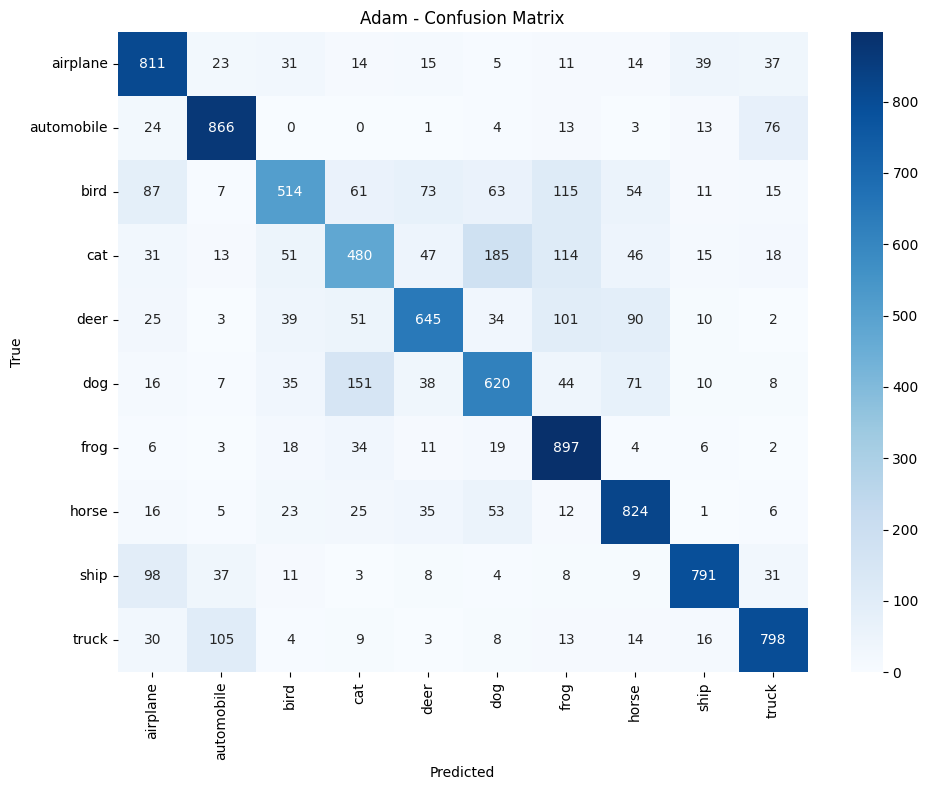

In [13]:
model_adam = CNN_CIFAR10(OUT_CHANNELS_1, OUT_CHANNELS_2)
optimizer_adam = optim.Adam(model_adam.parameters(), lr=0.001)

history_adam = train_model(model_adam, train_loader, val_loader, criterion,
                          optimizer_adam, NUM_EPOCHS, device, "Adam")
plot_training(history_adam, "Adam")

results_adam = evaluate_model(model_adam, test_loader, device, CLASS_NAMES)
plot_confusion(results_adam['confusion_matrix'], CLASS_NAMES, "Adam")

torch.save({'model': model_adam.state_dict(), 'history': history_adam, 'results': results_adam},
          f"{MODELS_DIR}/adam_model.pth")

## 11. Experiment 4: RMSprop


Training: RMSprop
Epoch  1/10 | Train: 1.9716/ 31.57% | Val: 1.6452/ 41.40% | Time: 9.8s
Epoch  2/10 | Train: 1.5696/ 43.20% | Val: 1.4009/ 49.54% | Time: 9.6s
Epoch  3/10 | Train: 1.4415/ 48.42% | Val: 1.3044/ 53.07% | Time: 9.6s
Epoch  4/10 | Train: 1.3359/ 52.32% | Val: 1.2482/ 56.29% | Time: 9.6s
Epoch  5/10 | Train: 1.2587/ 55.44% | Val: 1.1634/ 59.49% | Time: 9.6s
Epoch  6/10 | Train: 1.2056/ 57.60% | Val: 1.1183/ 61.24% | Time: 9.7s
Epoch  7/10 | Train: 1.1654/ 59.37% | Val: 1.1025/ 61.81% | Time: 9.7s
Epoch  8/10 | Train: 1.1211/ 61.03% | Val: 1.1533/ 60.72% | Time: 9.6s
Epoch  9/10 | Train: 1.0920/ 61.75% | Val: 1.0765/ 62.77% | Time: 9.5s
Epoch 10/10 | Train: 1.0729/ 62.41% | Val: 1.0800/ 63.02% | Time: 9.6s
Completed! Final Val Acc: 63.02%



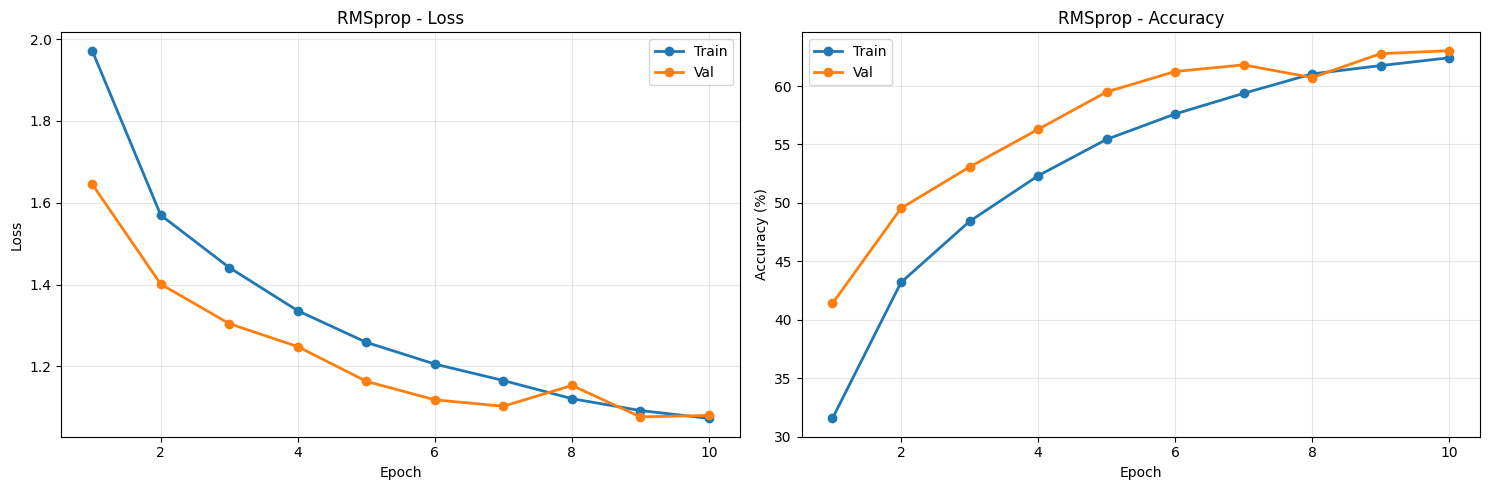

Test Accuracy: 64.03%


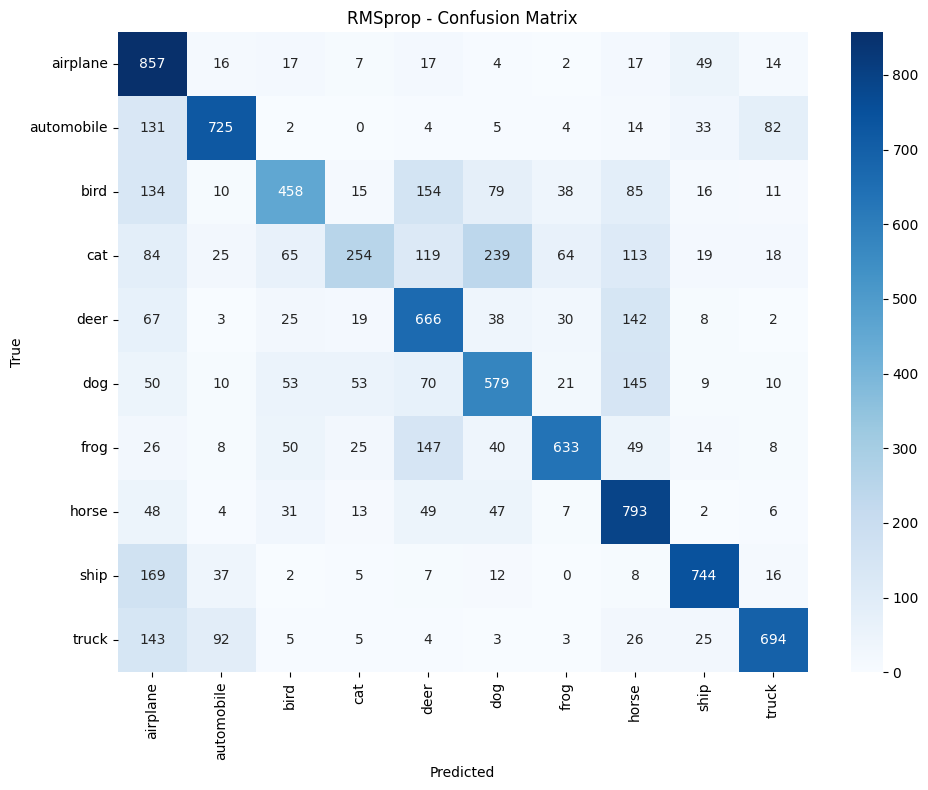

In [14]:
model_rms = CNN_CIFAR10(OUT_CHANNELS_1, OUT_CHANNELS_2)
optimizer_rms = optim.RMSprop(model_rms.parameters(), lr=0.001)

history_rms = train_model(model_rms, train_loader, val_loader, criterion,
                         optimizer_rms, NUM_EPOCHS, device, "RMSprop")
plot_training(history_rms, "RMSprop")

results_rms = evaluate_model(model_rms, test_loader, device, CLASS_NAMES)
plot_confusion(results_rms['confusion_matrix'], CLASS_NAMES, "RMSprop")

torch.save({'model': model_rms.state_dict(), 'history': history_rms, 'results': results_rms},
          f"{MODELS_DIR}/rmsprop_model.pth")

## 12. Comparative Analysis

In [26]:
experiments = ['SGD', 'SGD + Momentum', 'Adam', 'RMSprop']
results_list = [results_sgd, results_sgd_m, results_adam, results_rms]
histories = [history_sgd, history_sgd_m, history_adam, history_rms]

print("\n" + "="*80 + "\nALL EXPERIMENTS COMPLETED\n" + "="*80)


ALL EXPERIMENTS COMPLETED


### Comparison Table

In [27]:
data = []
for name, results, history in zip(experiments, results_list, histories):
    data.append({
        'Optimizer': name,
        'Train Acc': f"{history['train_acc'][-1]:.2f}%",
        'Val Acc': f"{history['val_acc'][-1]:.2f}%",
        'Test Acc': f"{results['accuracy']*100:.2f}%",
        'Train Loss': f"{history['train_loss'][-1]:.4f}",
        'Val Loss': f"{history['val_loss'][-1]:.4f}",
        'Avg Time (s)': f"{np.mean(history['epoch_times']):.1f}"
    })

df = pd.DataFrame(data)
print("\n" + df.to_string(index=False))
df.to_csv(f"{METRICS_DIR}/optimizer_comparison.csv", index=False)
print(f"\nSaved to: {METRICS_DIR}/optimizer_comparison.csv")


     Optimizer Train Acc Val Acc Test Acc Train Loss Val Loss Avg Time (s)
           SGD    67.45%  67.99%   68.30%     0.9393   0.9427         10.0
SGD + Momentum    71.03%  73.32%   73.07%     0.8436   0.7889          9.8
          Adam    69.03%  72.09%   72.46%     0.8917   0.8326          9.8
       RMSprop    62.41%  63.02%   64.03%     1.0729   1.0800          9.6

Saved to: ../results/metrics/optimizer_comparison.csv


### Test Accuracy Comparison

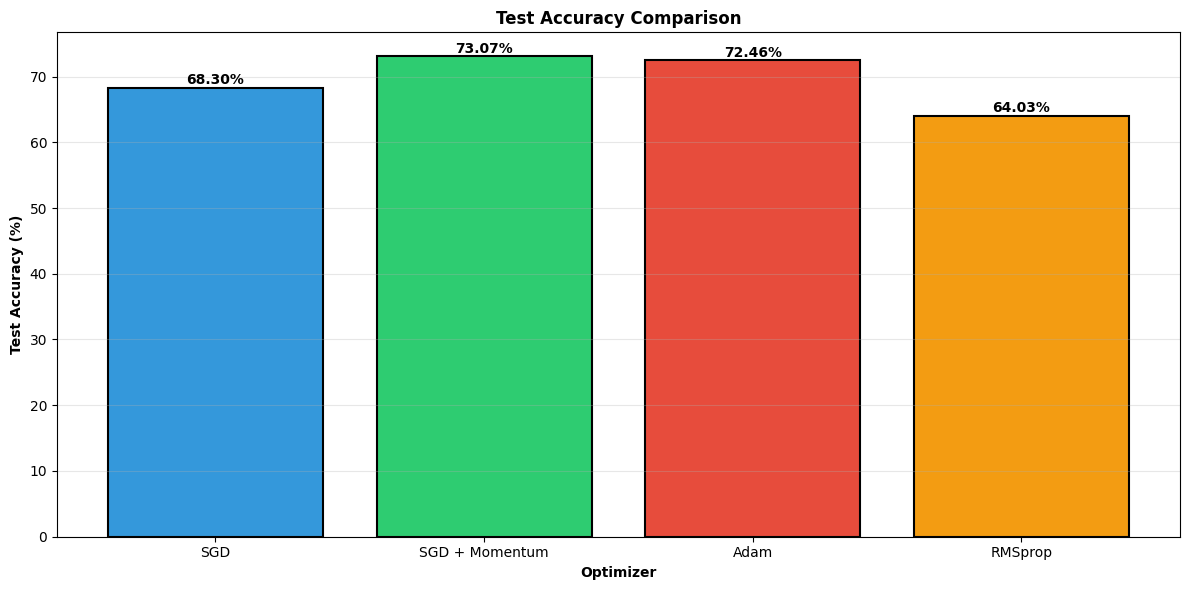

Best: SGD + Momentum (73.07%)


In [28]:
test_accs = [r['accuracy']*100 for r in results_list]
colors = ['#3498db', '#2ecc71', '#e74c3c', '#f39c12']

plt.figure(figsize=(12, 6))
bars = plt.bar(experiments, test_accs, color=colors, edgecolor='black', linewidth=1.5)
plt.xlabel('Optimizer', fontweight='bold')
plt.ylabel('Test Accuracy (%)', fontweight='bold')
plt.title('Test Accuracy Comparison', fontweight='bold')

for bar, acc in zip(bars, test_accs):
    plt.text(bar.get_x() + bar.get_width()/2, bar.get_height() + 0.5,
            f'{acc:.2f}%', ha='center', fontweight='bold')

plt.grid(axis='y', alpha=0.3)
plt.tight_layout()
plt.savefig(f"{PLOTS_DIR}/test_accuracy_comparison.png", dpi=150, bbox_inches='tight')
plt.show()

best = np.argmax(test_accs)
print(f"Best: {experiments[best]} ({test_accs[best]:.2f}%)")

### Validation Accuracy Convergence

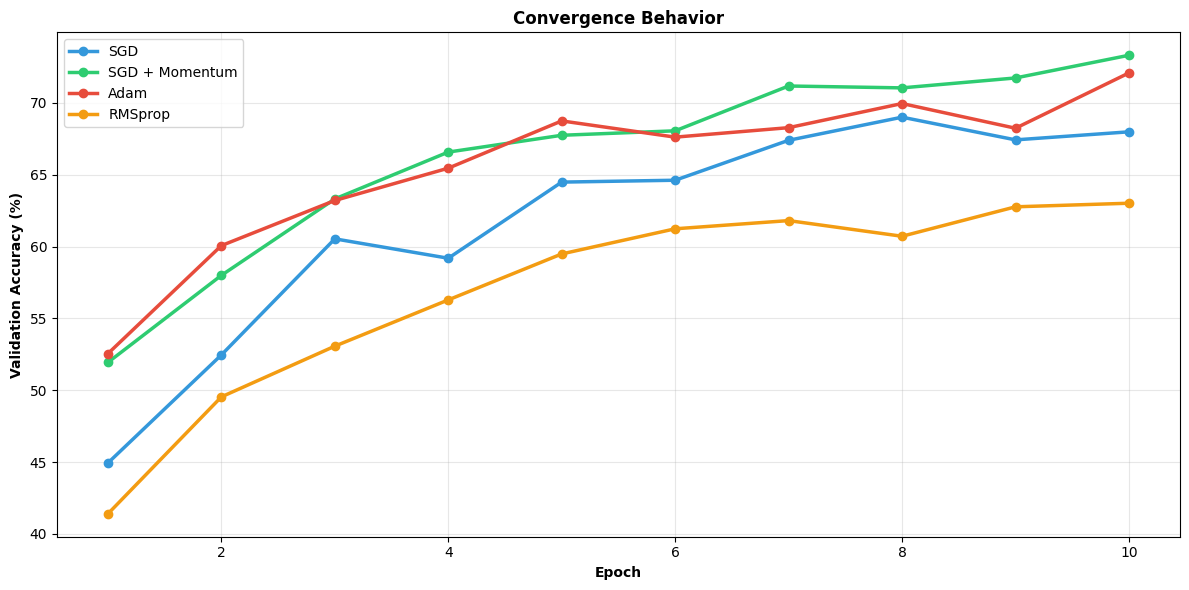

In [29]:
plt.figure(figsize=(12, 6))
for name, hist, color in zip(experiments, histories, colors):
    plt.plot(range(1, NUM_EPOCHS+1), hist['val_acc'], 'o-', 
            label=name, color=color, linewidth=2.5, markersize=6)

plt.xlabel('Epoch', fontweight='bold')
plt.ylabel('Validation Accuracy (%)', fontweight='bold')
plt.title('Convergence Behavior', fontweight='bold')
plt.legend()
plt.grid(alpha=0.3)
plt.tight_layout()
plt.savefig(f"{PLOTS_DIR}/val_accuracy_convergence.png", dpi=150, bbox_inches='tight')
plt.show()

### Validation Loss Comparison

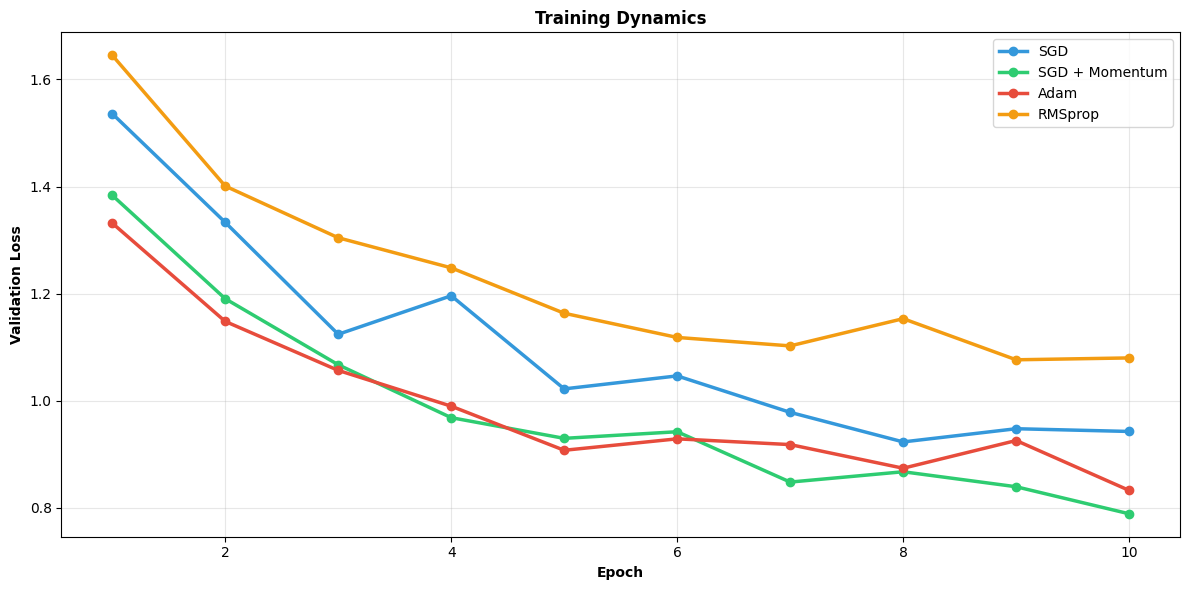

In [30]:
plt.figure(figsize=(12, 6))
for name, hist, color in zip(experiments, histories, colors):
    plt.plot(range(1, NUM_EPOCHS+1), hist['val_loss'], 'o-',
            label=name, color=color, linewidth=2.5, markersize=6)

plt.xlabel('Epoch', fontweight='bold')
plt.ylabel('Validation Loss', fontweight='bold')
plt.title('Training Dynamics', fontweight='bold')
plt.legend()
plt.grid(alpha=0.3)
plt.tight_layout()
plt.savefig(f"{PLOTS_DIR}/val_loss_comparison.png", dpi=150, bbox_inches='tight')
plt.show()

### Convergence Speed (Epochs to 60% Val Accuracy)

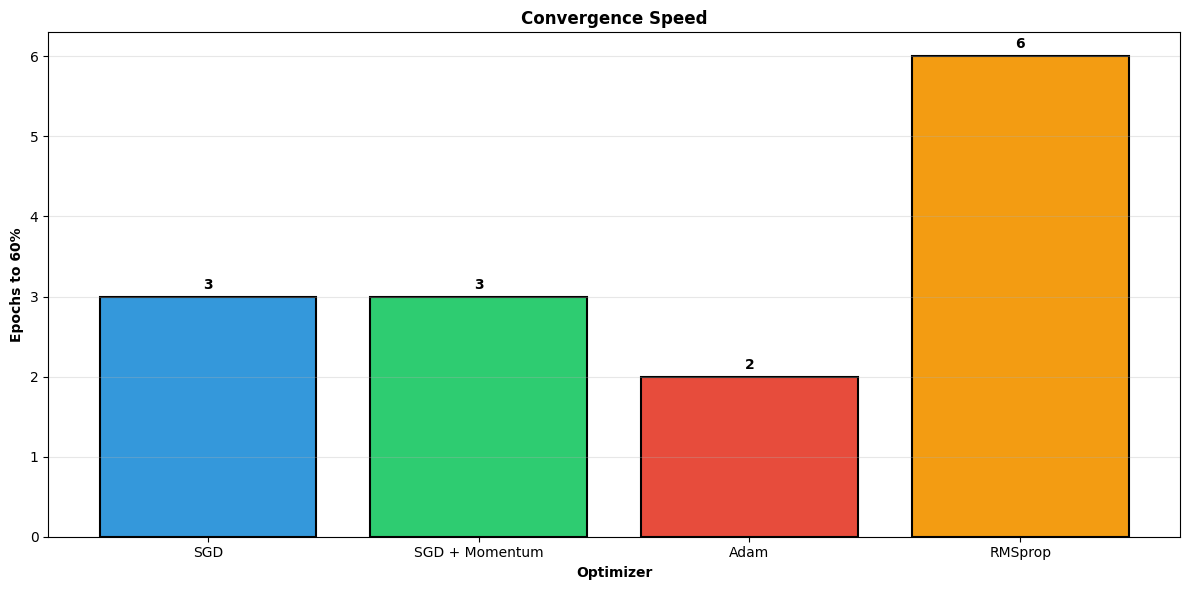

SGD                 : 3 epochs
SGD + Momentum      : 3 epochs
Adam                : 2 epochs
RMSprop             : 6 epochs


In [31]:
def epochs_to_threshold(history, threshold=60.0):
    for i, acc in enumerate(history['val_acc']):
        if acc >= threshold:
            return i + 1
    return len(history['val_acc'])

speeds = [epochs_to_threshold(h) for h in histories]

plt.figure(figsize=(12, 6))
bars = plt.bar(experiments, speeds, color=colors, edgecolor='black', linewidth=1.5)
plt.xlabel('Optimizer', fontweight='bold')
plt.ylabel('Epochs to 60%', fontweight='bold')
plt.title('Convergence Speed', fontweight='bold')

for bar, s in zip(bars, speeds):
    plt.text(bar.get_x() + bar.get_width()/2, bar.get_height() + 0.1,
            f'{s}', ha='center', fontweight='bold')

plt.grid(axis='y', alpha=0.3)
plt.tight_layout()
plt.savefig(f"{PLOTS_DIR}/convergence_speed.png", dpi=150, bbox_inches='tight')
plt.show()

for name, s in zip(experiments, speeds):
    print(f"{name:20s}: {s} epochs")

### Generalization Gap (Train - Test Accuracy)

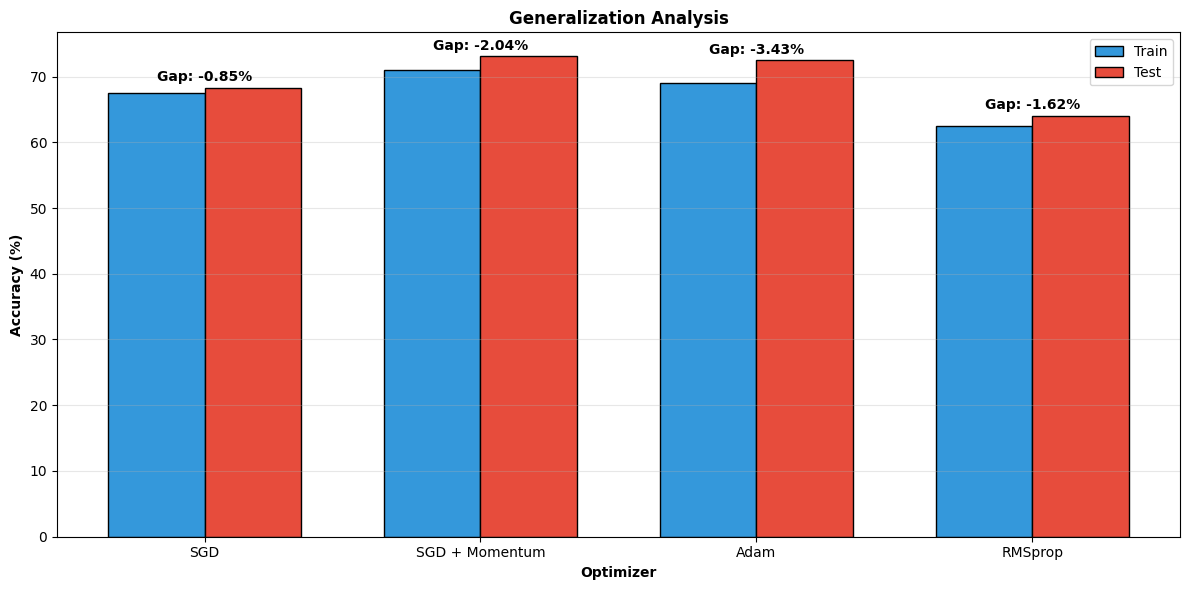

SGD                 : -0.85% (Good)
SGD + Momentum      : -2.04% (Good)
Adam                : -3.43% (Good)
RMSprop             : -1.62% (Good)


In [32]:
train_accs = [h['train_acc'][-1] for h in histories]
gaps = [train - test for train, test in zip(train_accs, test_accs)]

fig, ax = plt.subplots(figsize=(12, 6))
x = np.arange(len(experiments))
width = 0.35

ax.bar(x - width/2, train_accs, width, label='Train', color='#3498db', edgecolor='black')
ax.bar(x + width/2, test_accs, width, label='Test', color='#e74c3c', edgecolor='black')

ax.set_xlabel('Optimizer', fontweight='bold')
ax.set_ylabel('Accuracy (%)', fontweight='bold')
ax.set_title('Generalization Analysis', fontweight='bold')
ax.set_xticks(x)
ax.set_xticklabels(experiments)
ax.legend()
ax.grid(axis='y', alpha=0.3)

for i, gap in enumerate(gaps):
    ax.text(i, max(train_accs[i], test_accs[i]) + 1,
           f'Gap: {gap:.2f}%', ha='center', fontweight='bold')

plt.tight_layout()
plt.savefig(f"{PLOTS_DIR}/generalization_gap.png", dpi=150, bbox_inches='tight')
plt.show()

for name, gap in zip(experiments, gaps):
    status = "Good" if gap < 5 else "Overfitting" if gap > 10 else "Fair"
    print(f"{name:20s}: {gap:5.2f}% ({status})")

### Per-Class Accuracy

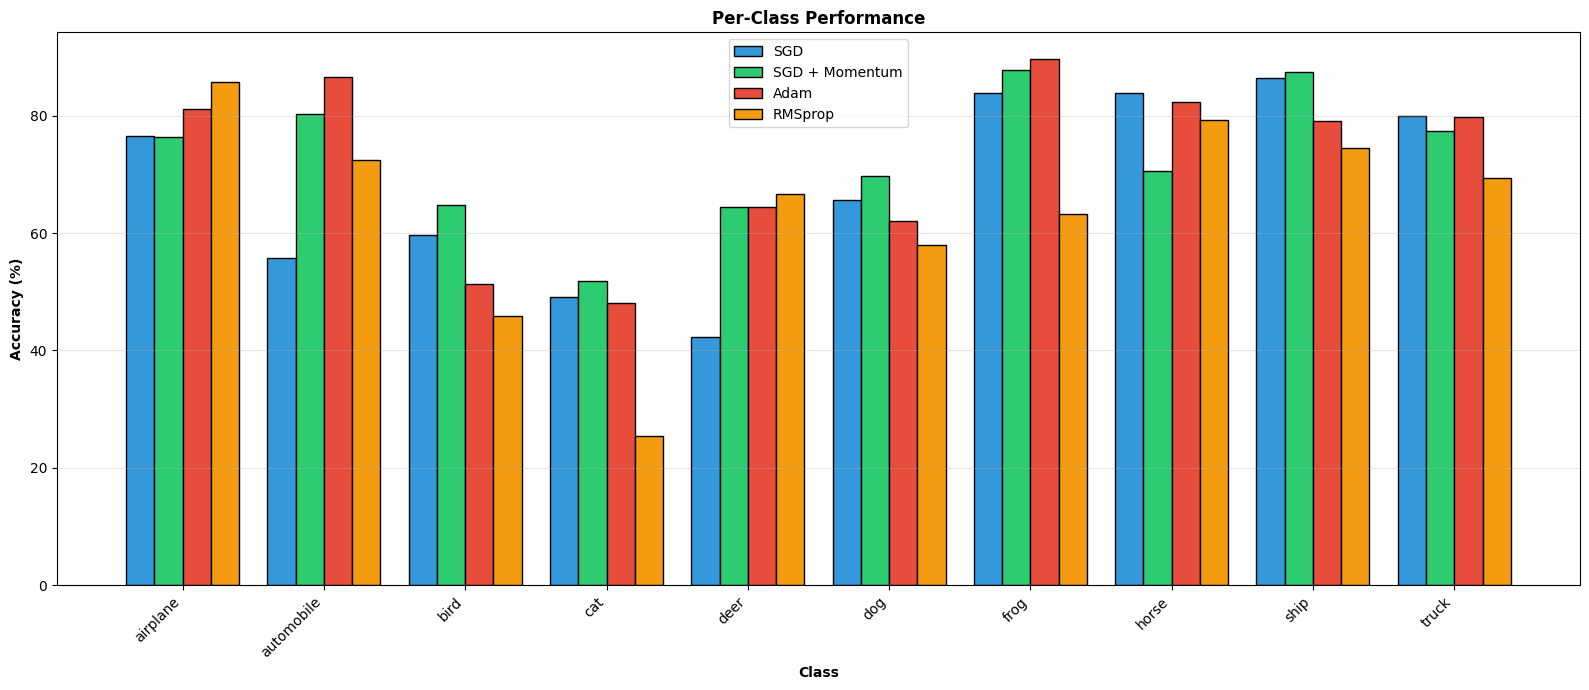

In [33]:
per_class = [[r['classification_report'][c]['recall']*100 for c in CLASS_NAMES] 
             for r in results_list]

fig, ax = plt.subplots(figsize=(16, 7))
x = np.arange(len(CLASS_NAMES))
width = 0.2

for i, (name, accs, color) in enumerate(zip(experiments, per_class, colors)):
    ax.bar(x + i*width, accs, width, label=name, color=color, edgecolor='black')

ax.set_xlabel('Class', fontweight='bold')
ax.set_ylabel('Accuracy (%)', fontweight='bold')
ax.set_title('Per-Class Performance', fontweight='bold')
ax.set_xticks(x + width * 1.5)
ax.set_xticklabels(CLASS_NAMES, rotation=45, ha='right')
ax.legend()
ax.grid(axis='y', alpha=0.3)

plt.tight_layout()
plt.savefig(f"{PLOTS_DIR}/per_class_accuracy.png", dpi=150, bbox_inches='tight')
plt.show()

## 13. Save Summary Report

In [34]:
summary = {
    'date': datetime.now().strftime("%Y-%m-%d %H:%M:%S"),
    'dataset': 'CIFAR-10',
    'architecture': {'conv1': OUT_CHANNELS_1, 'conv2': OUT_CHANNELS_2, 
                    'parameters': model_sgd.count_parameters()},
    'training': {'epochs': NUM_EPOCHS, 'batch_size': BATCH_SIZE},
    'experiments': {}
}

for name, results, hist in zip(experiments, results_list, histories):
    summary['experiments'][name] = {
        'train_acc': hist['train_acc'][-1],
        'val_acc': hist['val_acc'][-1],
        'test_acc': results['accuracy'] * 100,
        'convergence': epochs_to_threshold(hist),
        'gap': hist['train_acc'][-1] - results['accuracy'] * 100
    }

with open(f"{METRICS_DIR}/summary.json", 'w') as f:
    json.dump(summary, f, indent=4)

print("\n" + "="*80)
print("SUMMARY SAVED")
print("="*80)
print(f"Location: {METRICS_DIR}/summary.json")
print("\n🎉 ALL EXPERIMENTS COMPLETED SUCCESSFULLY! 🎉")
print(f"\nBest Optimizer: {experiments[np.argmax(test_accs)]} ({max(test_accs):.2f}%)")
print(f"Fastest Convergence: {experiments[np.argmin(speeds)]} ({min(speeds)} epochs)")
print(f"Best Generalization: {experiments[np.argmin(gaps)]} ({min(gaps):.2f}% gap)")


SUMMARY SAVED
Location: ../results/metrics/summary.json

🎉 ALL EXPERIMENTS COMPLETED SUCCESSFULLY! 🎉

Best Optimizer: SGD + Momentum (73.07%)
Fastest Convergence: Adam (2 epochs)
Best Generalization: Adam (-3.43% gap)


---

## Results Summary

All outputs saved to:
- **Models:** `../models/`
- **Plots:** `../results/plots/`  
- **Metrics:** `../results/metrics/`